# Soils Revealed precalculations

Libraries documentation:
- [Dask](https://docs.dask.org/en/latest/)
- [xarray](http://xarray.pydata.org/en/stable/index.html)
- [rioxarray](https://corteva.github.io/rioxarray/stable/index.html)
- [geocube](https://corteva.github.io/geocube/stable/installation.html)
- [rasterio](https://rasterio.readthedocs.io/en/latest/index.html)
- [rasterstats](https://pythonhosted.org/rasterstats/index.html)

In [1]:
import rasterio as rio
from rasterstats import zonal_stats
import rioxarray
import xarray as xr
import dask.array as da
import numpy as np
import geopandas as gpd
from geocube.api.core import make_geocube

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
def show_raster(image, colors, quantities, title=None):
    fig, ax = plt.subplots(figsize=(16,8.5))
    
    # Define the colors you want
    cmap = mpl.colors.ListedColormap(colors)
    # Define a normalization from values -> colors
    norm = mpl.colors.BoundaryNorm(quantities, len(colors))
    
    im = ax.imshow(image, cmap=cmap, norm=norm)
    if title:
        ax.set_title(title)
    ax.set_xlabel('Column #')
    ax.set_ylabel('Row #')
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    
    plt.colorbar(im, cax=cax)

In [3]:
def rasterio_zonal_statistics(df, image, epsg):
    stats = {}
    
    mean_list = []
    min_list = []
    max_list = []
    for i in range(len(df)):
        tmp_df = df.iloc[i:(i+1)]
        output = zonal_stats(tmp_df.to_crs(epsg=epsg), image, band=1, all_touched=True, raster_out=True, affine=profile['transform'], nodata=-999)

        mean_list.append(output[0]['mean'])
        min_list.append(output[0]['min'])
        max_list.append(output[0]['max'])
        
    df['mean'] = mean_list
    df['min'] = min_list
    df['max'] = max_list
    return df

In [4]:
def show_xarray(xds, colors=None, quantities=None):
    fig, ax = plt.subplots(figsize=(16,8.5))
    
    if colors and quantities:
        # Define the colors you want
        cmap = mpl.colors.ListedColormap(colors)
        # Define a normalization from values -> colors
        norm = mpl.colors.BoundaryNorm(quantities, len(colors))
        
        xds.plot(ax=ax, cmap=cmap, norm=norm)
    else:
        xds.plot(ax=ax)

**Political boundaries**

In [5]:
countries = gpd.read_file('../data/gadm36_0/gadm36_0.shp')
countries['geometry'] = countries['geometry'].apply(lambda x: x.simplify(0.0075))

DriverError: ../data/gadm36_0/gadm36_0.shp: No such file or directory

In [ ]:
fig, ax = plt.subplots(figsize=(16,8.5))
countries.plot(ax=ax)

**Rasters**

In [7]:
Historic_SOCS_2010 = 'https://storage.googleapis.com/vizz-data-transfer/SOC_maps/Historic/SOCS_0_200cm_year_2010AD_10km.tif'
Historic_SOCS_NoLU = 'https://storage.googleapis.com/vizz-data-transfer/SOC_maps/Historic/SOCS_0_200cm_year_NoLU_10km.tif'

## Zonal statistics with [rasterio](https://geohackweek.github.io/raster/04-workingwithrasters/)

In [8]:
with rio.open(Historic_SOCS_2010) as src:
    print(src.profile)
    crs = src.profile.get('crs')
    
epsg = str(crs).split(':')[1]

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': None, 'width': 4008, 'height': 2004, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.08983152841195215, 0.0, -180.0223829375521,
       0.0, -0.08983152841195215, 90.01119146877605), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}


### Request the image

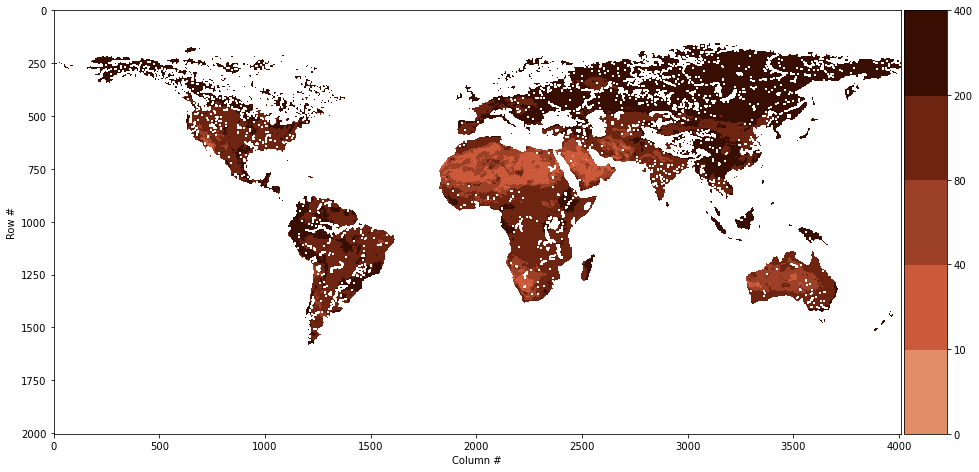

In [9]:
with rio.open(Historic_SOCS_2010) as src:
    profile = src.profile
    image = src.read(1)

    image = image.astype('f4')
    image[image==0] = np.nan

colors = ["#E18D67", "#CB5A3A", "#9D4028", "#6D2410", "#380E03"]
quantities = [0, 10, 40, 80, 200, 400]

show_raster(image, colors, quantities, title=None)

### Subtract rasters

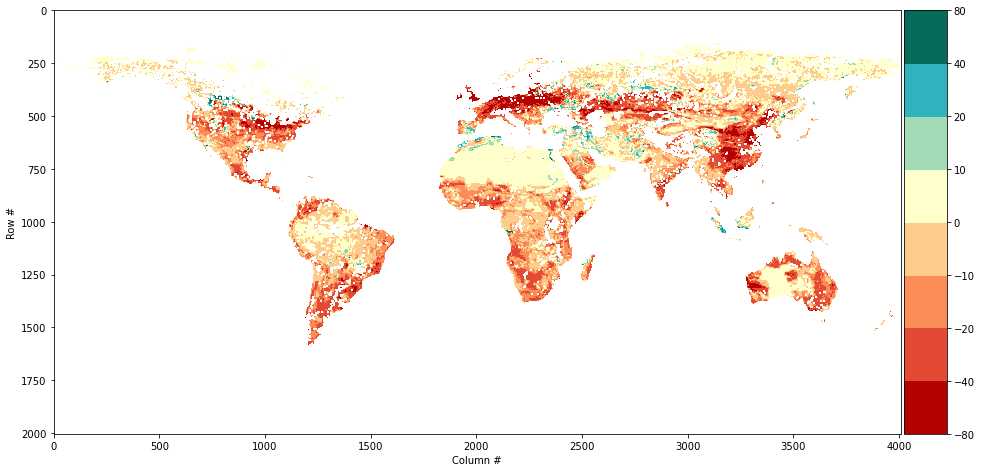

In [10]:
with rio.open(Historic_SOCS_2010) as src:
    historic_2010 = src.read(1)
    historic_2010 = historic_2010.astype('f4')
    historic_2010[historic_2010==0] = np.nan
    
with rio.open(Historic_SOCS_NoLU) as src:
    historic_NoLU = src.read(1)
    historic_NoLU = historic_NoLU.astype('f4')
    historic_NoLU[historic_NoLU==0] = np.nan
    
delta = historic_2010 - historic_NoLU

colors = ["#B30200", "#E34A33", "#FC8D59", "#FDCC8A", "#FFFFCC", "#A1DAB4", "#31B3BD", "#1C9099", "#066C59"]
quantities = [-80, -40, -20, -10, 0, 10, 20, 40, 80]

show_raster(delta, colors, quantities, title=None)

### Zonal statistics

Pixels of data = 6736
Maximum SOC stock change = 71.00
Min. SOC stock change =-76.00
Mean SOC stock change =-2.72
CPU times: user 74.9 ms, sys: 8.08 ms, total: 83 ms
Wall time: 94.4 ms


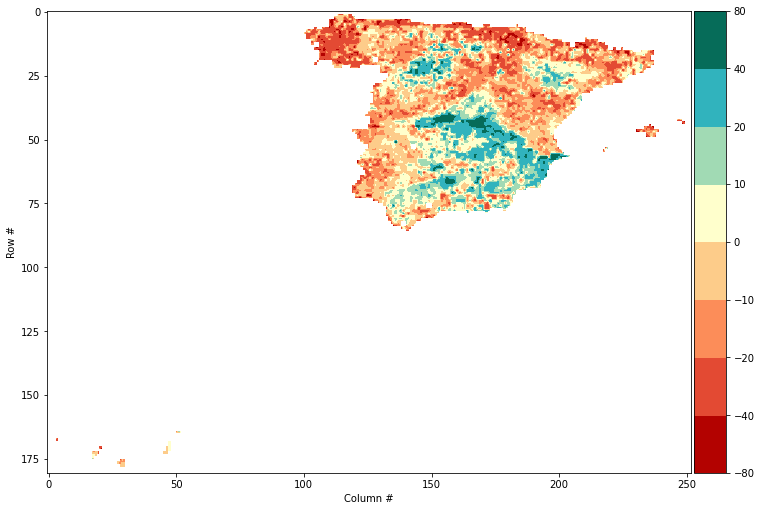

In [11]:
%%time
df = countries[countries['NAME_0'] == 'Spain'].copy()
output = zonal_stats(df.to_crs(epsg=epsg), delta, band=1, all_touched=True,
                     raster_out=True, affine=profile['transform'], nodata=-999)

out_img = output[0]['mini_raster_array']

show_raster(out_img, colors, quantities, title=None)

print(f"Pixels of data = {output[0]['count']}")
print(f"Maximum SOC stock change = {output[0]['max']:5.2f}")
print(f"Min. SOC stock change ={output[0]['min']:5.2f}")
print(f"Mean SOC stock change ={output[0]['mean']:5.2f}")

**All countries**

In [12]:
%%time
df = rasterio_zonal_statistics(countries, delta, epsg)

CPU times: user 18 s, sys: 1.63 s, total: 19.6 s
Wall time: 20 s


In [13]:
df.sort_values(by='mean')

,GID_0,NAME_0,geometry,mean,min,max
62,DNK,Denmark,"MULTIPOLYGON (((11.51250 54.62542, 11.51194 54...",-73.097990,-217.0,26.0
106,IRL,Ireland,"MULTIPOLYGON (((-10.60417 52.06347, -10.60361 ...",-60.622021,-215.0,135.0
179,POL,Poland,"MULTIPOLYGON (((14.82318 50.87067, 14.82343 50...",-60.143674,-210.0,133.0
79,GBR,United Kingdom,"MULTIPOLYGON (((-6.38792 49.86875, -6.38625 49...",-58.174900,-206.0,102.0
28,BLR,Belarus,"POLYGON ((24.39463 51.91308, 24.33585 51.83478...",-55.625676,-236.0,735.0
...,...,...,...,...,...,...
243,WLF,Wallis and Futuna,"MULTIPOLYGON (((-178.05360 -14.32028, -178.028...",NaN,NaN,NaN
244,WSM,Samoa,"MULTIPOLYGON (((-171.40787 -14.07156, -171.405...",NaN,NaN,NaN
247,XCL,Clipperton Island,"POLYGON ((-109.22542 10.32042, -109.19903 10.3...",NaN,NaN,NaN
250,XPI,Paracel Islands,"MULTIPOLYGON (((112.25397 16.99448, 112.28150 ...",NaN,NaN,NaN


## Zonal statistics with [xarray](https://corteva.github.io/rioxarray/stable/examples/clip_geom.html#Load-in-xarray-dataset)

In [44]:
xda = rioxarray.open_rasterio(Historic_SOCS_2010)

# Mask data
xda = xda.where(xda > 0.)
xda

<xarray.DataArray (band: 1, y: 2004, x: 4008)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * band         (band) int64 1
  * y            (y) float64 89.97 89.88 89.79 89.7 ... -89.79 -89.88 -89.97
  * x            (x) float64 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
    spatial_ref  int64 0
Attributes:
    transform:     (0.08983152841195215, 0.0, -180.0223829375521, 0.0, -0.089...
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     b1
    grid_mapping:  spatial_ref

CPU times: user 510 ms, sys: 93 ms, total: 603 ms
Wall time: 661 ms


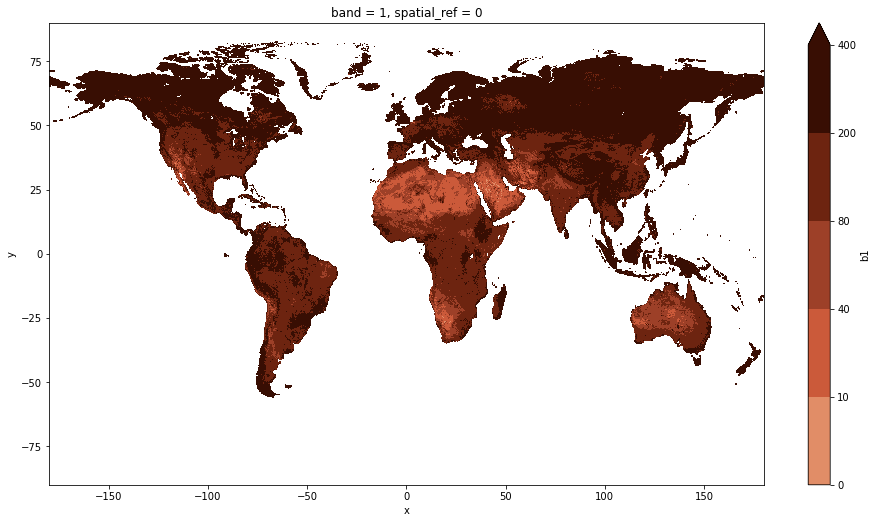

In [45]:
%%time
colors = ["#E18D67", "#CB5A3A", "#9D4028", "#6D2410", "#380E03"]
quantities = [0, 10, 40, 80, 200, 400]
show_xarray(xda, colors, quantities)

### Subtract rasters

**Read `GeoTiff` as `xarray.DataArray`**

In [47]:
xda_NoLU = rioxarray.open_rasterio(Historic_SOCS_NoLU)
xda_2010 = rioxarray.open_rasterio(Historic_SOCS_2010)
xda_2010

CPU times: user 47.1 ms, sys: 4.3 ms, total: 51.4 ms
Wall time: 51.2 ms


<xarray.DataArray (band: 1, y: 2004, x: 4008)>
[8032032 values with dtype=int16]
Coordinates:
  * band         (band) int64 1
  * y            (y) float64 89.97 89.88 89.79 89.7 ... -89.79 -89.88 -89.97
  * x            (x) float64 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
    spatial_ref  int64 0
Attributes:
    transform:     (0.08983152841195215, 0.0, -180.0223829375521, 0.0, -0.089...
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     b1
    grid_mapping:  spatial_ref

**Mask data**

In [19]:
xda_2010 = xda_2010.where(xda_2010 > 0.)
xda_NoLU = xda_NoLU.where(xda_NoLU > 0.)

#### Subtract rasters

**`numpy array`**

In [76]:
%%time
na_delta = xda_2010.data - xda_NoLU.data

CPU times: user 12.1 ms, sys: 44.1 ms, total: 56.2 ms
Wall time: 86.3 ms


**`xarray.DataArrays`**

From `xarray.DataArrays` will reassign the `dask array`

In [77]:
da_2010 = da.from_array(xda_2010.data, chunks=256)
da_NoLU = da.from_array(xda_NoLU.data, chunks=256)
da_2010

dask.array<array, shape=(1, 2004, 4008), dtype=int16, chunksize=(1, 256, 256), chunktype=numpy.ndarray>

Subtract dask arrays

In [78]:
%%time
na_delta = (da_2010 - da_NoLU).compute()

CPU times: user 80.5 ms, sys: 42.2 ms, total: 123 ms
Wall time: 102 ms


**From `numpy array` to `xarray.DataArray`**

In [22]:
xda_delta = xr.DataArray(na_delta, coords=xda_2010.coords, dims=xda_2010.dims, attrs=xda_2010.attrs.copy())
xda_delta

<xarray.DataArray (band: 1, y: 2004, x: 4008)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * band         (band) int64 1
  * y            (y) float64 89.97 89.88 89.79 89.7 ... -89.79 -89.88 -89.97
  * x            (x) float64 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
    spatial_ref  int64 0
Attributes:
    transform:     (0.08983152841195215, 0.0, -180.0223829375521, 0.0, -0.089...
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     b1
    grid_mapping:  spatial_ref

**Display `xarray.DataArray`**

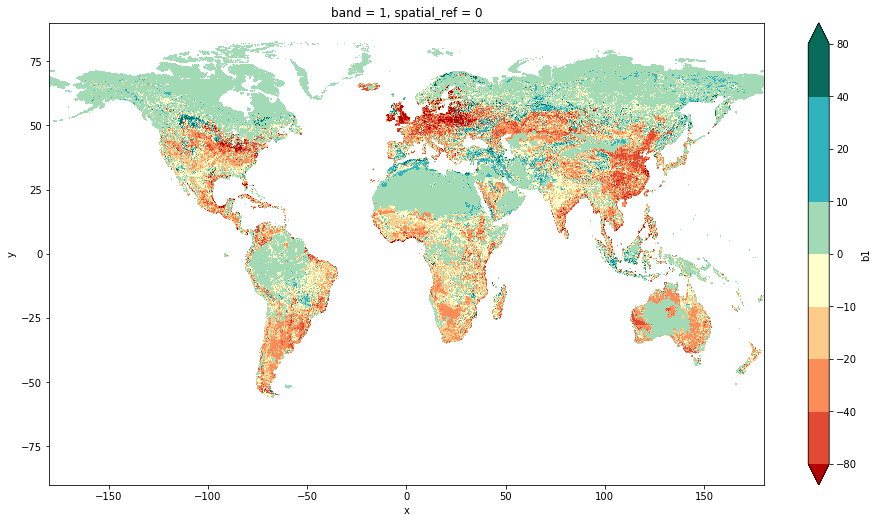

In [23]:
colors = ["#B30200", "#E34A33", "#FC8D59", "#FDCC8A", "#FFFFCC", "#A1DAB4", "#31B3BD", "#1C9099", "#066C59"]
quantities = [-80, -40, -20, -10, 0, 10, 20, 40, 80]
show_xarray(xda_delta, colors, quantities)

### Zonal statistics
**Raster data**

In [58]:
raster = xda_delta.squeeze().drop("band")
raster.name = "raster"
raster

<xarray.DataArray 'raster' (y: 2004, x: 4008)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * y            (y) float64 89.97 89.88 89.79 89.7 ... -89.79 -89.88 -89.97
  * x            (x) float64 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
    spatial_ref  int64 0
Attributes:
    transform:     (0.08983152841195215, 0.0, -180.0223829375521, 0.0, -0.089...
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     b1
    grid_mapping:  spatial_ref

**Create the data mask by rasterizing the vector data**

In [25]:
countries.reset_index(level=0, inplace=True)
countries.head()

,index,GID_0,NAME_0,geometry,mean,min,max
0,0,ABW,Aruba,"POLYGON ((-69.97820 12.46986, -70.06347 12.539...",NaN,NaN,NaN
1,1,AFG,Afghanistan,"POLYGON ((68.52644 31.75435, 68.58202 31.75034...",-0.352582,-84.0,96.0
2,2,AGO,Angola,"MULTIPOLYGON (((11.73347 -16.67255, 11.74014 -...",-15.319272,-75.0,378.0
3,3,AIA,Anguilla,"MULTIPOLYGON (((-63.42375 18.58903, -63.42403 ...",0.000000,0.0,0.0
4,4,ALA,Åland,"MULTIPOLYGON (((21.32195 59.74986, 21.32472 59...",-9.947368,-84.0,24.0


In [63]:
%%time
out_grid = make_geocube(
    vector_data=countries,
    measurements=["index"],
    like=raster, # ensure the data are on the same grid
    fill=np.nan
)
out_grid

CPU times: user 6.99 s, sys: 1.34 s, total: 8.34 s
Wall time: 8.4 s


<xarray.Dataset>
Dimensions:      (x: 4008, y: 2004)
Coordinates:
  * y            (y) float64 89.97 89.88 89.79 89.7 ... -89.79 -89.88 -89.97
  * x            (x) float64 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
    spatial_ref  int64 0
Data variables:
    index        (y, x) float64 nan nan nan nan nan ... 11.0 11.0 11.0 11.0 11.0
Attributes:
    grid_mapping:  spatial_ref

**Create a `xarray.Dataset` by merging both `xarray.Datasets`**

In [64]:
out_grid["raster"] = raster
out_grid

<xarray.Dataset>
Dimensions:      (x: 4008, y: 2004)
Coordinates:
  * y            (y) float64 89.97 89.88 89.79 89.7 ... -89.79 -89.88 -89.97
  * x            (x) float64 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
    spatial_ref  int64 0
Data variables:
    index        (y, x) float64 nan nan nan nan nan ... 11.0 11.0 11.0 11.0 11.0
    raster       (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    grid_mapping:  spatial_ref

In [73]:
%%time
grouped_xds = out_grid.drop("spatial_ref").groupby(out_grid.index)

CPU times: user 1.81 s, sys: 559 ms, total: 2.37 s
Wall time: 2.39 s


In [74]:
%%time
grid_mean = grouped_xds.mean().rename({"raster": "mean"})
grid_min = grouped_xds.min().rename({"raster": "min"})
grid_max = grouped_xds.max().rename({"raster": "max"})
grid_std = grouped_xds.std().rename({"raster": "std"})

/Users/ikersanchez/anaconda3/envs/geoenv/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CPU times: user 5.32 s, sys: 122 ms, total: 5.44 s
Wall time: 5.56 s


In [75]:
zonal_stats = xr.merge([grid_mean, grid_min, grid_max, grid_std])
zonal_stats.to_dataframe()

,spatial_ref,mean,min,max,std
index,,,,,
0.0,0,NaN,NaN,NaN,NaN
1.0,0,-0.146674,-84.0,96.0,17.755027
2.0,0,-15.461031,-75.0,71.0,10.743632
3.0,0,NaN,NaN,NaN,NaN
4.0,0,-15.666667,-84.0,24.0,26.090198
...,...,...,...,...,...
249.0,0,4.875000,-19.0,30.0,10.011712
252.0,0,-2.187753,-56.0,91.0,13.729416
253.0,0,-16.227445,-85.0,108.0,10.608022
